In [1]:
!pip install rasterio
!pip install fiona
!pip install pysatproc
!pip install unetseg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 45.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 18.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.9 MB/s eta 0:00:00
  Created wheel for pysatproc: filename=pysatproc-0.1.9-py2.py3-none-any.whl size=35759 sha256=c21ad35129f599b238ad1da654649d7fe7bcf7b48748c4494755936df55bf924
  Stored in directory: /root/.cache/pip/wheels/62/00/27/ec5c2b97f1a0cdfba672d1273ac7a6b4

In [1]:
!nvidia-smi

Fri Jan 13 14:44:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
chip_size = 160

labels_folder = "/content/drive/MyDrive/Basurales/AMBA/ENTREGAS_MASCARAS/OCTUBRE_2022/ANOTACIONES/2021-DICIEMBRE/"
imagery_files = "/content/drive/MyDrive/Basurales/AMBA/labels/ANOTACIONES/2021-DICIEMBRE/DIC-2021-AMBA-SENTINEL_RGB.tif"
aoi_file = "/content/drive/MyDrive/Basurales/AMBA/labels/AREA_DE_INTERES/RMBA_bounding_box.gpkg"

chips_folder = "/tmp/chips/inference/"


In [5]:
# Set para predicción

!satproc_extract_chips \
    $imagery_files \
    -o $chips_folder \
    --aoi $aoi_file \
    --size $chip_size \
    --step-size $chip_size 

Rasters:   0% 0/1 [00:00<?, ?it/s]
DIC-2021-AMBA-SENTINEL_RGB.tif windows:   0% 0/6214 [00:00<?, ?it/s]
DIC-2021-AMBA-SENTINEL_RGB.tif windows:   0% 1/6214 [00:01<2:49:16,  1.63s/it]
DIC-2021-AMBA-SENTINEL_RGB.tif windows:   0% 23/6214 [00:01<06:12, 16.62it/s] 
DIC-2021-AMBA-SENTINEL_RGB.tif windows:   1% 50/6214 [00:01<02:33, 40.19it/s]
DIC-2021-AMBA-SENTINEL_RGB.tif windows:   1% 72/6214 [00:02<01:40, 61.31it/s]
DIC-2021-AMBA-SENTINEL_RGB.tif windows:   2% 96/6214 [00:02<01:14, 82.62it/s]
DIC-2021-AMBA-SENTINEL_RGB.tif windows:   2% 141/6214 [00:02<00:42, 142.04it/s]
DIC-2021-AMBA-SENTINEL_RGB.tif windows:   3% 169/6214 [00:02<00:38, 157.19it/s]
DIC-2021-AMBA-SENTINEL_RGB.tif windows:   3% 196/6214 [00:02<00:33, 179.79it/s]
DIC-2021-AMBA-SENTINEL_RGB.tif windows:   4% 230/6214 [00:02<00:27, 215.36it/s]
DIC-2021-AMBA-SENTINEL_RGB.tif windows:   4% 258/6214 [00:02<00:28, 210.48it/s]
DIC-2021-AMBA-SENTINEL_RGB.tif windows:   5% 284/6214 [00:02<00:27, 216.31it/s]
DIC-2021-AMBA-SENTINEL_R

## Predicción / Inferencia

In [6]:
from unetseg.predict import PredictConfig, predict
from unetseg.evaluate import plot_data_results
import os

In [7]:
# batch size: cantidad de datos que se procesan por vez, puede ser limitado por 
# la memoria de gpu disponible 
batch = 150

# tamaño de la imagen procesada por la UNet (debe ser multiplos de 16 , por ej 160, 320, etc) y lo mas parecida posible a la resolucion de los chips
unet_input_size = chip_size

# carpeta donde guardar los chips con predicción
model_predictions_path = '/tmp/inference/model_predictions/'

# de donde leer el modelo (ruta y nombre de archivo)
model_file = '/content/drive/MyDrive/Basurales/AMBA/models/2023_01_chipsize_160_48.h5'

In [8]:
predict_config = PredictConfig(images_path = chips_folder, # ruta a las imagenes sobre las cuales queremos predecir. Usar las que tienen step size igual al ancho!
                               results_path = model_predictions_path, # ruta de destino para nuestra predicción
                               batch_size = batch,
                               model_path = model_file, # ruta al modelo (.h5)
                               height = unet_input_size,
                               width = unet_input_size,
                               n_channels = 3,
                               n_classes = 1)

In [9]:
predict(predict_config)

Total images to predict (/tmp/chips/inference/images/*.tif): 6214
After skipping existing results: 6214


  0%|          | 0/42 [00:00<?, ?it/s]

5/5 [==============================] - 14s 693ms/step


  2%|▏         | 1/42 [00:22<15:24, 22.56s/it]

5/5 [==============================] - 0s 96ms/step


  5%|▍         | 2/42 [00:24<06:56, 10.41s/it]

5/5 [==============================] - 0s 79ms/step


  7%|▋         | 3/42 [00:26<04:13,  6.51s/it]

5/5 [==============================] - 0s 78ms/step


 10%|▉         | 4/42 [00:28<02:57,  4.67s/it]

5/5 [==============================] - 0s 78ms/step


 12%|█▏        | 5/42 [00:29<02:14,  3.64s/it]

5/5 [==============================] - 0s 78ms/step


 14%|█▍        | 6/42 [00:31<01:48,  3.02s/it]

5/5 [==============================] - 0s 78ms/step


 17%|█▋        | 7/42 [00:33<01:34,  2.70s/it]

5/5 [==============================] - 0s 78ms/step


 19%|█▉        | 8/42 [00:35<01:24,  2.48s/it]

5/5 [==============================] - 0s 79ms/step


 21%|██▏       | 9/42 [00:37<01:14,  2.26s/it]

5/5 [==============================] - 0s 80ms/step


 24%|██▍       | 10/42 [00:39<01:07,  2.11s/it]

5/5 [==============================] - 0s 78ms/step


 26%|██▌       | 11/42 [00:41<01:02,  2.00s/it]

5/5 [==============================] - 0s 80ms/step


 29%|██▊       | 12/42 [00:42<00:57,  1.93s/it]

5/5 [==============================] - 0s 79ms/step


 31%|███       | 13/42 [00:44<00:54,  1.87s/it]

5/5 [==============================] - 0s 79ms/step


 33%|███▎      | 14/42 [00:46<00:51,  1.83s/it]

5/5 [==============================] - 0s 79ms/step


 36%|███▌      | 15/42 [00:48<00:48,  1.80s/it]

5/5 [==============================] - 0s 79ms/step


 38%|███▊      | 16/42 [00:49<00:46,  1.77s/it]

5/5 [==============================] - 0s 78ms/step


 40%|████      | 17/42 [00:51<00:45,  1.82s/it]

5/5 [==============================] - 0s 79ms/step


 43%|████▎     | 18/42 [00:53<00:44,  1.86s/it]

5/5 [==============================] - 0s 79ms/step


 45%|████▌     | 19/42 [00:55<00:43,  1.88s/it]

5/5 [==============================] - 0s 80ms/step


 48%|████▊     | 20/42 [00:57<00:42,  1.91s/it]

5/5 [==============================] - 0s 80ms/step


 50%|█████     | 21/42 [00:59<00:40,  1.94s/it]

5/5 [==============================] - 0s 78ms/step


 52%|█████▏    | 22/42 [01:01<00:37,  1.86s/it]

5/5 [==============================] - 0s 79ms/step


 55%|█████▍    | 23/42 [01:03<00:34,  1.82s/it]

5/5 [==============================] - 0s 81ms/step


 57%|█████▋    | 24/42 [01:04<00:32,  1.80s/it]

5/5 [==============================] - 0s 82ms/step


 60%|█████▉    | 25/42 [01:06<00:31,  1.87s/it]

5/5 [==============================] - 0s 79ms/step


 62%|██████▏   | 26/42 [01:08<00:30,  1.88s/it]

5/5 [==============================] - 0s 81ms/step


 64%|██████▍   | 27/42 [01:10<00:28,  1.88s/it]

5/5 [==============================] - 0s 81ms/step


 67%|██████▋   | 28/42 [01:12<00:26,  1.88s/it]

5/5 [==============================] - 0s 82ms/step


 69%|██████▉   | 29/42 [01:14<00:23,  1.82s/it]

5/5 [==============================] - 0s 79ms/step


 71%|███████▏  | 30/42 [01:16<00:22,  1.86s/it]

5/5 [==============================] - 0s 79ms/step


 74%|███████▍  | 31/42 [01:17<00:20,  1.86s/it]

5/5 [==============================] - 0s 81ms/step


 76%|███████▌  | 32/42 [01:19<00:17,  1.79s/it]

5/5 [==============================] - 0s 80ms/step


 79%|███████▊  | 33/42 [01:21<00:15,  1.78s/it]

5/5 [==============================] - 0s 80ms/step


 81%|████████  | 34/42 [01:22<00:13,  1.73s/it]

5/5 [==============================] - 0s 79ms/step


 83%|████████▎ | 35/42 [01:24<00:12,  1.80s/it]

5/5 [==============================] - 0s 80ms/step


 86%|████████▌ | 36/42 [01:26<00:10,  1.73s/it]

5/5 [==============================] - 0s 79ms/step


 88%|████████▊ | 37/42 [01:28<00:08,  1.68s/it]

5/5 [==============================] - 0s 81ms/step


 90%|█████████ | 38/42 [01:29<00:06,  1.64s/it]

5/5 [==============================] - 0s 79ms/step


 93%|█████████▎| 39/42 [01:31<00:04,  1.61s/it]

5/5 [==============================] - 0s 80ms/step


 95%|█████████▌| 40/42 [01:32<00:03,  1.65s/it]

5/5 [==============================] - 0s 79ms/step


 98%|█████████▊| 41/42 [01:34<00:01,  1.69s/it]

2/2 [==============================] - 0s 75ms/step


100%|██████████| 42/42 [01:35<00:00,  2.27s/it]

Done!


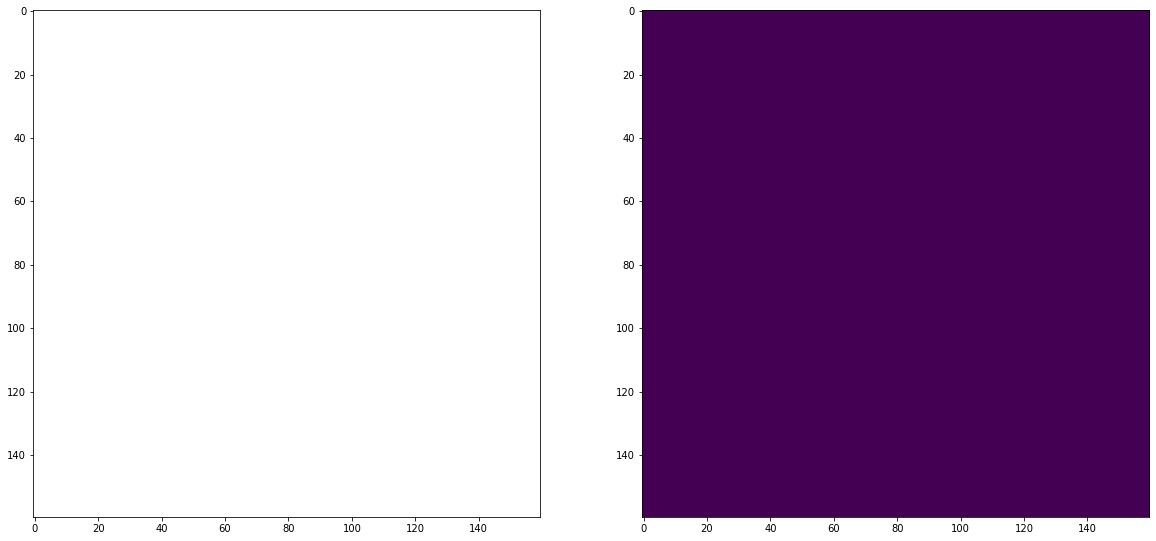

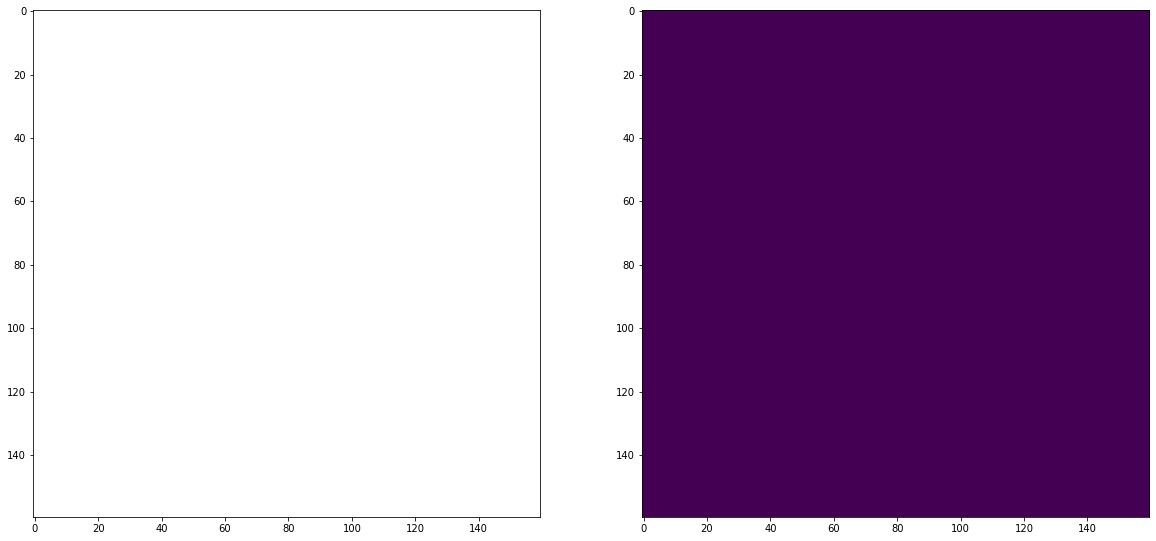

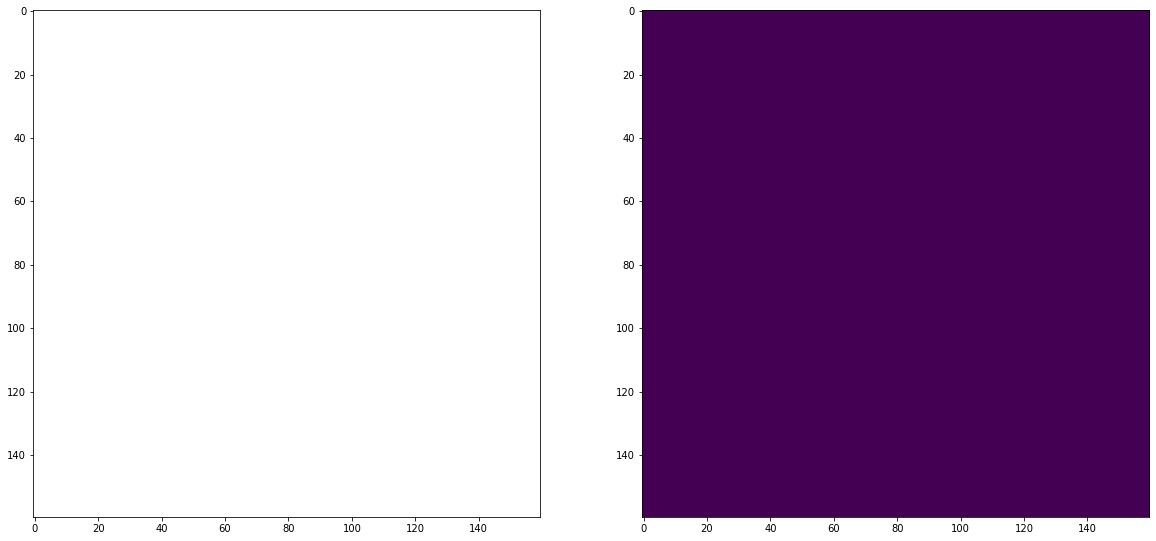

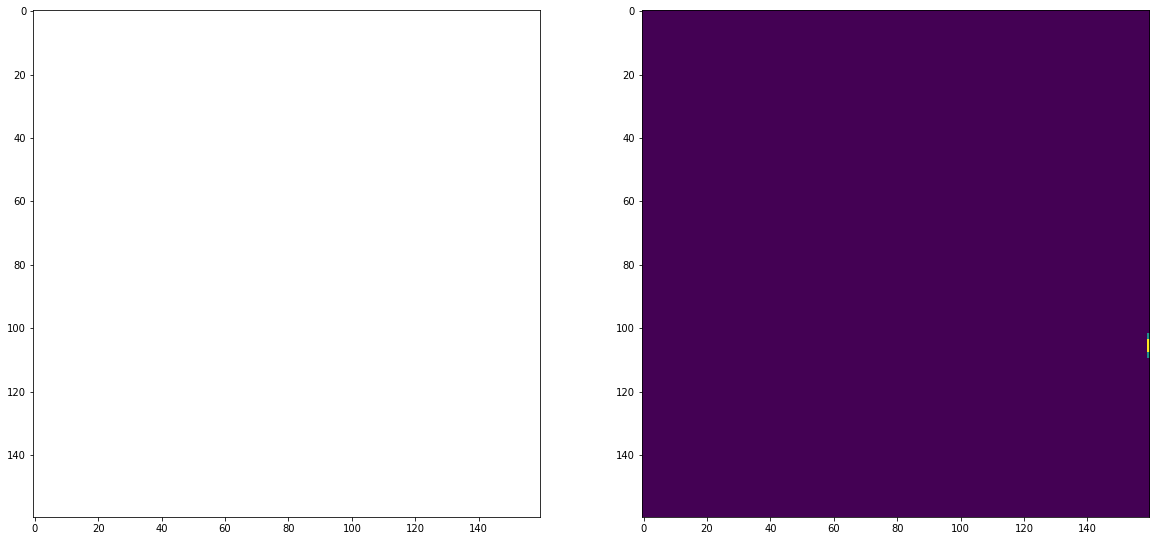

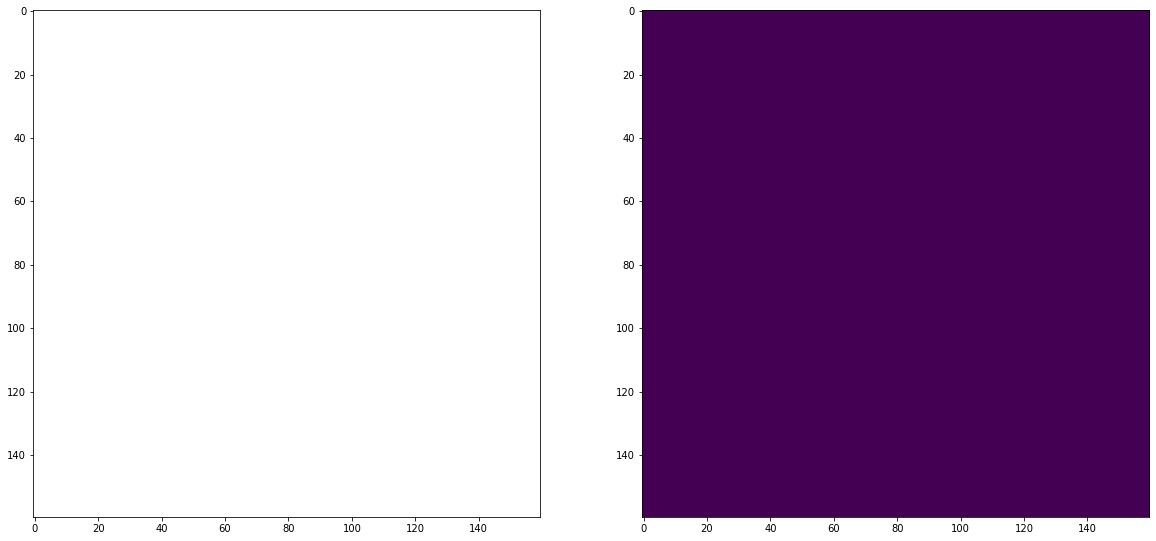

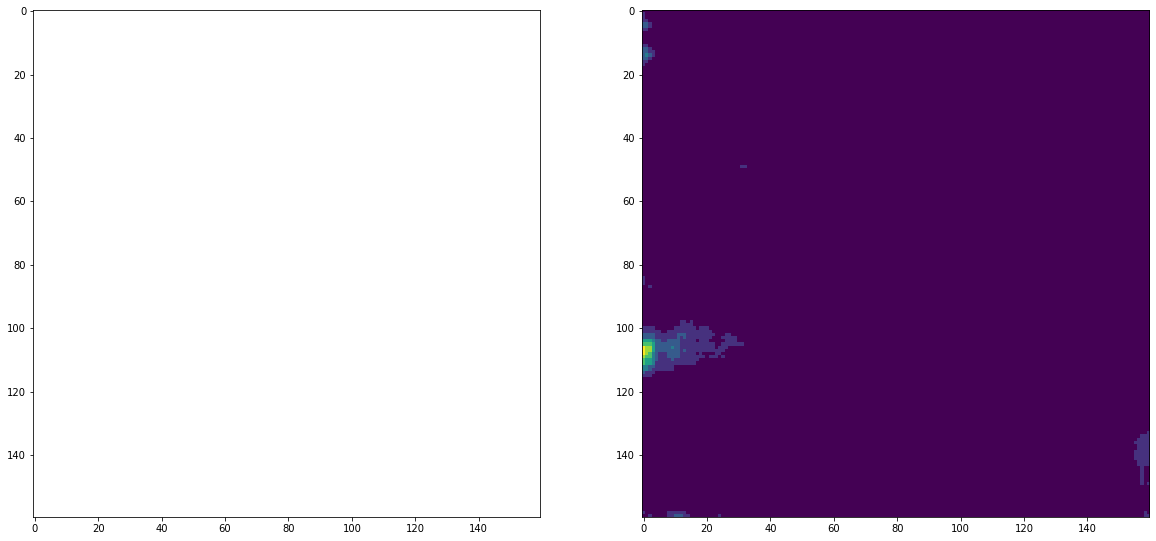

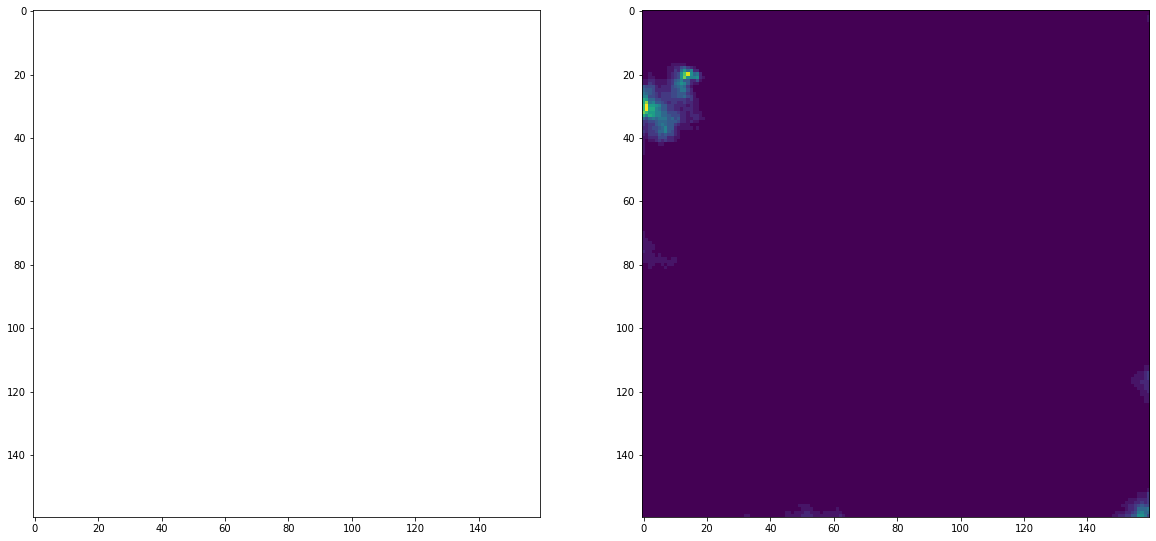

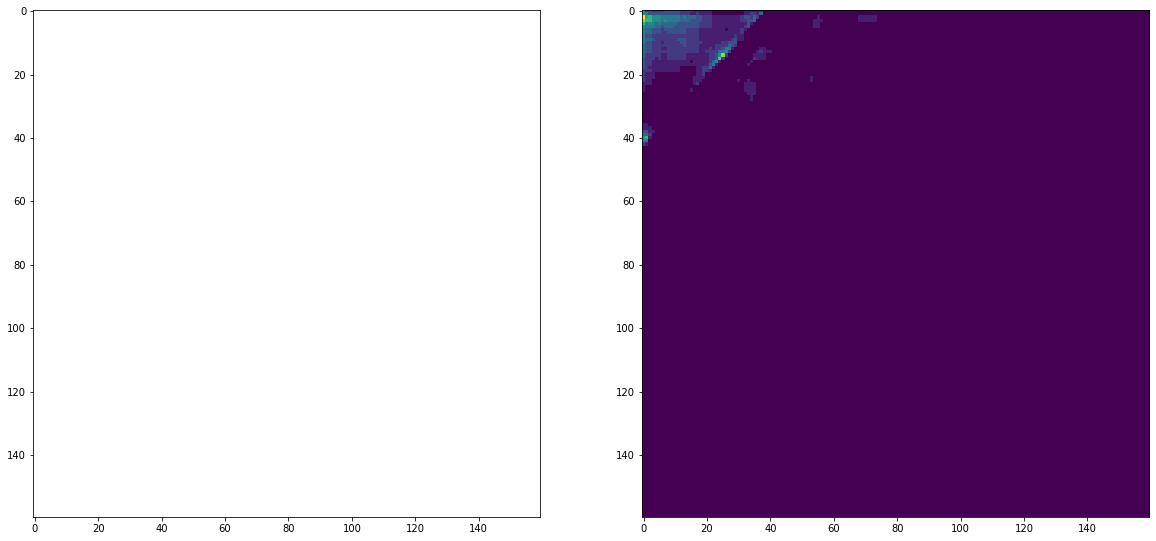

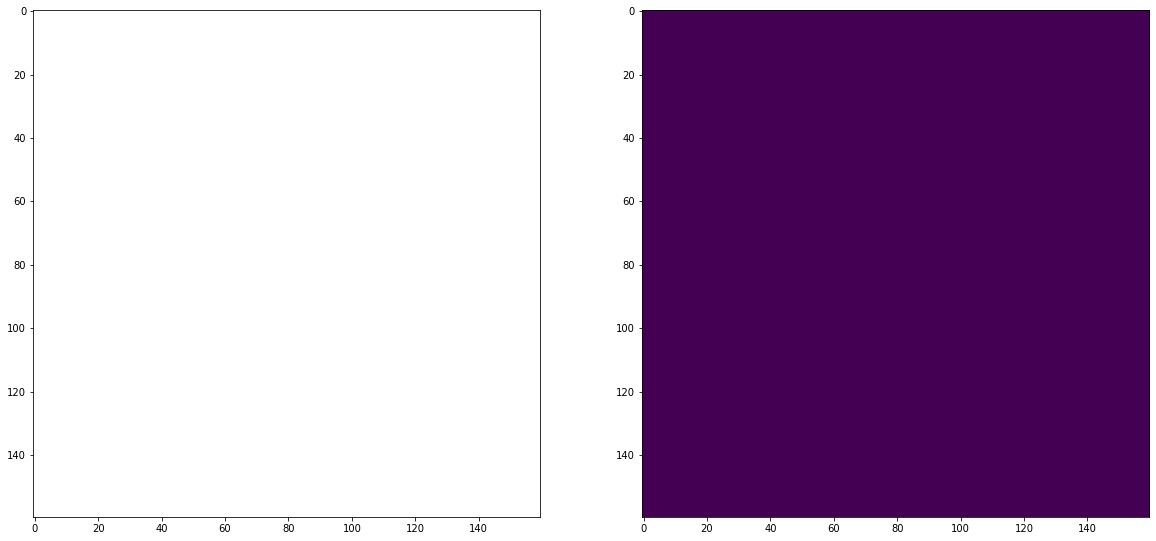

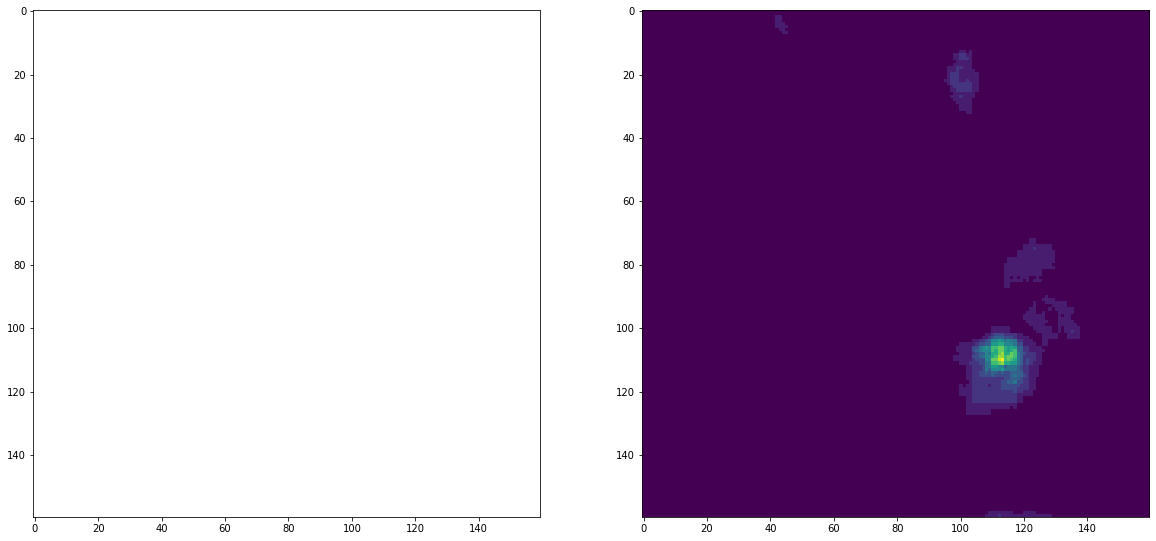

In [10]:
plot_data_results(num_samples=10, fig_size=(1, 1), predict_config=predict_config, img_ch = 3)

## Postprocesamiento - generar shapefile con los resultados

In [11]:
from satproc.postprocess.polygonize import polygonize 
from satproc.filter import filter_by_max_prob

from pathlib import Path

In [12]:
# umbral de corte - se descartan los pixeles con probabilidad menor
thresh = 0.6

input_path_unfiltered = model_predictions_path
output_path_filtered = '/tmp/inference/predictions_filtered_' + str(thresh).replace(".", "") + '/'


filter_by_max_prob(input_dir = input_path_unfiltered,
                   output_dir = output_path_filtered,
                   threshold = thresh)

# ahora generamos polígonos con los pixeles que superan el umbral
input_path = output_path_filtered
output_path = '/tmp/inference/polygons/predictions_thresh_' + str(thresh).replace(".", "") + '.gpkg' # archivo con el resultado final


polygonize(threshold = thresh,
           input_dir = input_path,
           output = output_path)


Dissolve: 100%|##########| 6/6 [00:02<00:00,  2.46it/s]
/usr/local/lib/python3.8/dist-packages/satproc/postprocess/polygonize.py:132: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if shp.type == "MultiPolygon":


In [13]:
# Definimos el area mínima
# Atención que la unidad de medida de área depende del sistema de proyección de coordenadas (CRS) que use el archivo georreferenciado
# Aquí trabajamos con m2

# fijamos el umbral de área mínima en 1 Ha / 10000 m2
min_area = 10000

# el archivo con las predicciones del modelo
predictions_file = output_path

# el nombre de la capa que contiene es igual al nombre de archivo, sin la extensión 
layer_name = Path(output_path).stem

# donde vamos a guardar la versión filtrada
results_file = "/tmp/inference/polygons/" + layer_name + "_area_min_" + str(min_area) + "m.gpkg"

# a filtrar
!ogr2ogr -f "GPKG" \
    -sql "SELECT * FROM $layer_name m WHERE ST_Area(geom) > $min_area" \
    -dialect SQLITE \
    -nln results \
    $results_file \
    $predictions_file

In [14]:
# Reproyectamos / especificamos proyeccion

src_file = results_file
#dst_file = results_file[:-5] + "_utm.gpkg"

dst_file = '/content/drive/MyDrive/Basurales/AMBA/output/DIC_2021_thresh_06_area_min_10000m_utm.gpkg'

# Transformar
#!ogr2ogr -s_srs EPSG:4326 -t_srs EPSG:32720 -f 'GPKG' $dst_file $src_file

# Solo aclarar cual es la proj
!ogr2ogr -a_srs EPSG:32721 -f 'GPKG' $dst_file $src_file

In [ ]:
!ls -ld $dst_file

-rw------- 1 root root 4268032 Nov  4 02:57 /content/drive/MyDrive/Basurales/AMBA/ENTREGAS_MASCARAS/OCTUBRE_2022/PREDICCIONES/DIC_2021_thresh_06_area_min_10000m_utm.gpkg
